## Import 

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box, from_file
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import minimize
from sklearn.metrics import jaccard_score
import cv2
import seaborn as sns
import geopandas as gpd
import folium
import contextily as cx

from sklearn.model_selection import StratifiedKFold, KFold
import torch
print(torch.__version__)
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
import segmentation_models_pytorch as smp
# from torchmetrics import FBetaScore
import ttach as tta

import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger, CSVLogger
from pytorch_lightning import LightningDataModule, LightningModule

# import wandb
# wandb.login(key=os.environ["WANDB_API_KEY"])

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

1.10.2
1.6.5


In [2]:
cfg = {"eps":1e-5}
cfg = Box(cfg)

In [3]:
DATA_CSV = '../data/001_Fire_Only/001_seed417.csv'

In [4]:
data_df = pd.read_csv(DATA_CSV)
print(data_df.shape)

(534, 6)


In [5]:
data_df.head(12)

name  \
0   012b8863-976c-44e1-a491-9adf19c1cbba_0   
1   0328d12a-4ad8-4504-8ac5-70089db10b4e_0   
2   0328d12a-4ad8-4504-8ac5-70089db10b4e_1   
3   03790d1a-5b9c-48ed-820d-83abbe656035_0   
4   03790d1a-5b9c-48ed-820d-83abbe656035_1   
5   039885ad-e4f2-461e-9784-60508d0a7ab5_0   
6   039885ad-e4f2-461e-9784-60508d0a7ab5_1   
7   039885ad-e4f2-461e-9784-60508d0a7ab5_2   
8   039885ad-e4f2-461e-9784-60508d0a7ab5_3   
9   051de91d-9d50-423a-a130-4e51bd0d33f7_0   
10  058dcb9e-f349-40bf-868b-7afa8dc9bb5a_0   
11  05cfef86-3e27-42be-a0cb-a61fe2f89e40_0   

                                                                 feature  \
0   ../data/001_Fire_Only/img/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy   
1   ../data/001_Fire_Only/img/0328d12a-4ad8-4504-8ac5-70089db10b4e_0.npy   
2   ../data/001_Fire_Only/img/0328d12a-4ad8-4504-8ac5-70089db10b4e_1.npy   
3   ../data/001_Fire_Only/img/03790d1a-5b9c-48ed-820d-83abbe656035_0.npy   
4   ../data/001_Fire_Only/img/03790d1a-5b9c-48ed-820d-83abbe656035_1.npy   
5   ../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_0.npy   
6   ../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_1.npy   
7   ../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_2.npy   
8   ../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_3.npy   
9   ../data/001_Fire_Only/img/051de91d-9d50-423a-a130-4e51bd0d33f7_0.npy   
10  ../data/001_Fire_Only/img/058dcb9e-f349-40bf-868b-7afa8dc9bb5a_0.npy   
11  ../data/001_Fire_Only/img/05cfef86-3e27-42be-a0cb-a61fe2f89e40_0.npy   

                                                                    mask  \
0   ../data/001_Fire_Only/ann/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy   
1   ../data/001_Fire_Only/ann/0328d12a-4ad8-4504-8ac5-70089db10b4e_0.npy   
2   ../data/001_Fire_Only/ann/0328d12a-4ad8-4504-8ac5-70089db10b4e_1.npy   
3   ../data/001_Fire_Only/ann/03790d1a-5b9c-48ed-820d-83abbe656035_0.npy   
4   ../data/001_Fire_Only/ann/03790d1a-5b9c-48ed-820d-83abbe656035_1.npy   
5   ../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_0.npy   
6   ../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_1.npy   
7   ../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_2.npy   
8   ../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_3.npy   
9   ../data/001_Fire_Only/ann/051de91d-9d50-423a-a130-4e51bd0d33f7_0.npy   
10  ../data/001_Fire_Only/ann/058dcb9e-f349-40bf-868b-7afa8dc9bb5a_0.npy   
11  ../data/001_Fire_Only/ann/05cfef86-3e27-42be-a0cb-a61fe2f89e40_0.npy   

    defects  fold  cv  
0     False     1   3  
1     False     4   3  
2     False     4   0  
3     False     3   3  
4     False     3   3  
5     False     1   1  
6     False     1   3  
7     False     1   0  
8     False     1   1  
9     False     4   0  
10    False     3   1  
11     True     1   2

In [6]:
OUTPUT_ROOT = '../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold0/inference_cloud/visualize/'

In [7]:
cloud_predict_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT,'*_predict.png')))

# Check

In [19]:
pair_df = data_df[data_df.defects==False]

name  \
0    012b8863-976c-44e1-a491-9adf19c1cbba_0   
1    0328d12a-4ad8-4504-8ac5-70089db10b4e_0   
2    0328d12a-4ad8-4504-8ac5-70089db10b4e_1   
3    03790d1a-5b9c-48ed-820d-83abbe656035_0   
4    03790d1a-5b9c-48ed-820d-83abbe656035_1   
..                                      ...   
526  fafc9450-3cf9-4c7f-85d9-baa5671905a6_0   
527  fc98afd4-94d8-4470-bcab-f85b96097c13_0   
530  fe3eec1e-2204-4cde-a2ef-56be8b5effca_0   
531  fe3eec1e-2204-4cde-a2ef-56be8b5effca_1   
532  feb08801-64b1-4d11-a3fc-0efaad1f4274_0   

                                                                  feature  \
0    ../data/001_Fire_Only/img/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy   
1    ../data/001_Fire_Only/img/0328d12a-4ad8-4504-8ac5-70089db10b4e_0.npy   
2    ../data/001_Fire_Only/img/0328d12a-4ad8-4504-8ac5-70089db10b4e_1.npy   
3    ../data/001_Fire_Only/img/03790d1a-5b9c-48ed-820d-83abbe656035_0.npy   
4    ../data/001_Fire_Only/img/03790d1a-5b9c-48ed-820d-83abbe656035_1.npy   
..                                                                    ...   
526  ../data/001_Fire_Only/img/fafc9450-3cf9-4c7f-85d9-baa5671905a6_0.npy   
527  ../data/001_Fire_Only/img/fc98afd4-94d8-4470-bcab-f85b96097c13_0.npy   
530  ../data/001_Fire_Only/img/fe3eec1e-2204-4cde-a2ef-56be8b5effca_0.npy   
531  ../data/001_Fire_Only/img/fe3eec1e-2204-4cde-a2ef-56be8b5effca_1.npy   
532  ../data/001_Fire_Only/img/feb08801-64b1-4d11-a3fc-0efaad1f4274_0.npy   

                                                                     mask  \
0    ../data/001_Fire_Only/ann/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy   
1    ../data/001_Fire_Only/ann/0328d12a-4ad8-4504-8ac5-70089db10b4e_0.npy   
2    ../data/001_Fire_Only/ann/0328d12a-4ad8-4504-8ac5-70089db10b4e_1.npy   
3    ../data/001_Fire_Only/ann/03790d1a-5b9c-48ed-820d-83abbe656035_0.npy   
4    ../data/001_Fire_Only/ann/03790d1a-5b9c-48ed-820d-83abbe656035_1.npy   
..                                                                    ...   
526  ../data/001_Fire_Only/ann/fafc9450-3cf9-4c7f-85d9-baa5671905a6_0.npy   
527  ../data/001_Fire_Only/ann/fc98afd4-94d8-4470-bcab-f85b96097c13_0.npy   
530  ../data/001_Fire_Only/ann/fe3eec1e-2204-4cde-a2ef-56be8b5effca_0.npy   
531  ../data/001_Fire_Only/ann/fe3eec1e-2204-4cde-a2ef-56be8b5effca_1.npy   
532  ../data/001_Fire_Only/ann/feb08801-64b1-4d11-a3fc-0efaad1f4274_0.npy   

     defects  fold  cv  
0      False     1   3  
1      False     4   3  
2      False     4   0  
3      False     3   3  
4      False     3   3  
..       ...   ...  ..  
526    False     2   3  
527    False     3   1  
530    False     1   0  
531    False     1   0  
532    False     4   2  

[356 rows x 6 columns]

In [20]:
idx = 0
name = data_df['name'].iloc[idx]
print(idx, name)

0 012b8863-976c-44e1-a491-9adf19c1cbba_0


In [21]:
mask = np.load(data_df['mask'].iloc[idx]).squeeze()

In [39]:
cloud_predict_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT,name+'*.png')), reverse=True)
cloud_predict_paths

['../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold3/inference_cloud/visualize/10e9b0b6-f9df-4c1d-9c1e-503cb7e37b7b_1_pre_predict.png',
 '../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold3/inference_cloud/visualize/10e9b0b6-f9df-4c1d-9c1e-503cb7e37b7b_1_pre_2348.png',
 '../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold3/inference_cloud/visualize/10e9b0b6-f9df-4c1d-9c1e-503cb7e37b7b_1_pos_predict.png',
 '../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold3/inference_cloud/visualize/10e9b0b6-f9df-4c1d-9c1e-503cb7e37b7b_1_pos_2348.png']

In [93]:
thr = 0.5
thr_pxl = 255*thr

In [94]:
OUTPUT_ROOT = '../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold1/inference_cloud/visualize/'
print(OUTPUT_ROOT)

../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold1/inference_cloud/visualize/


In [96]:
keep_idx = []
for k in range(len(pair_df)):
    name = pair_df['name'].iloc[k]
    mask_path = pair_df['mask'].iloc[k]
    try:
        mask = np.load(mask_path).squeeze()
        pre_proba = np.zeros((512,512))
        pos_proba = np.zeros((512,512))
        for i in range(4):
            OUTPUT_ROOT = f'../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold{i}/inference_cloud/visualize/'
            if i==0:
                pre_image = cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pre_2348.png'))
                pos_image = cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pos_2348.png'))
                pre_image = cv2.cvtColor(pre_image, cv2.COLOR_BGR2RGB)
                pos_image = cv2.cvtColor(pos_image, cv2.COLOR_BGR2RGB)
            pre_proba += cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pre_predict.png'),0)
            pos_proba += cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pos_predict.png'),0)
        pre_proba /= 4
        pos_proba /= 4
        pre_pred = pre_proba>thr_pxl
        pos_pred = pos_proba>thr_pxl

        # metrics
        tp = (pre_pred * pos_pred).sum()
        tn = ((1. - pos_pred) * (1. - pre_pred)).sum()
        fp = (pos_pred * (1. - pre_pred)).sum()
        fn = ((1. - pos_pred) * pre_pred).sum()

        precision = tp / (tp + fp + cfg.eps)
        recall = tp / (tp + fn + cfg.eps)
        f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
        iou = tp / (tp + fp + fn + cfg.eps)

        if iou>thr:
            print(k, name, f1, iou)
            keep_idx.append(k)
        
    except Exception as e:
        # pass
        print(k, name, e)

24 0ff249de-784d-4760-a039-ed9f92eca60c_2 0.733601882167923 0.579288007142783
80 3cad4ddc-255e-4337-9541-198c8f44aa78_0 0.7167583654943969 0.5585585333982642
87 46705f46-b244-4e09-bcea-18ff46e133db_0 0.6726465666843383 0.5067628448443386
97 4cdaac91-4a11-42aa-b704-597eac54cbd5_1 0.9411703806504782 0.8888879012356653
103 52dce185-840f-44c4-ad02-a894b66ba6ab_0 0.9333279407674533 0.8749996354168186
264 c7543fd1-821f-428d-a847-9db9ee7f73ee_0 0.8821498922154245 0.7891565789664712
294 dd8686af-3b0a-43e7-930c-fadc0ac7049c_0 0.9999949999564463 0.9999999999314464


7 4 10


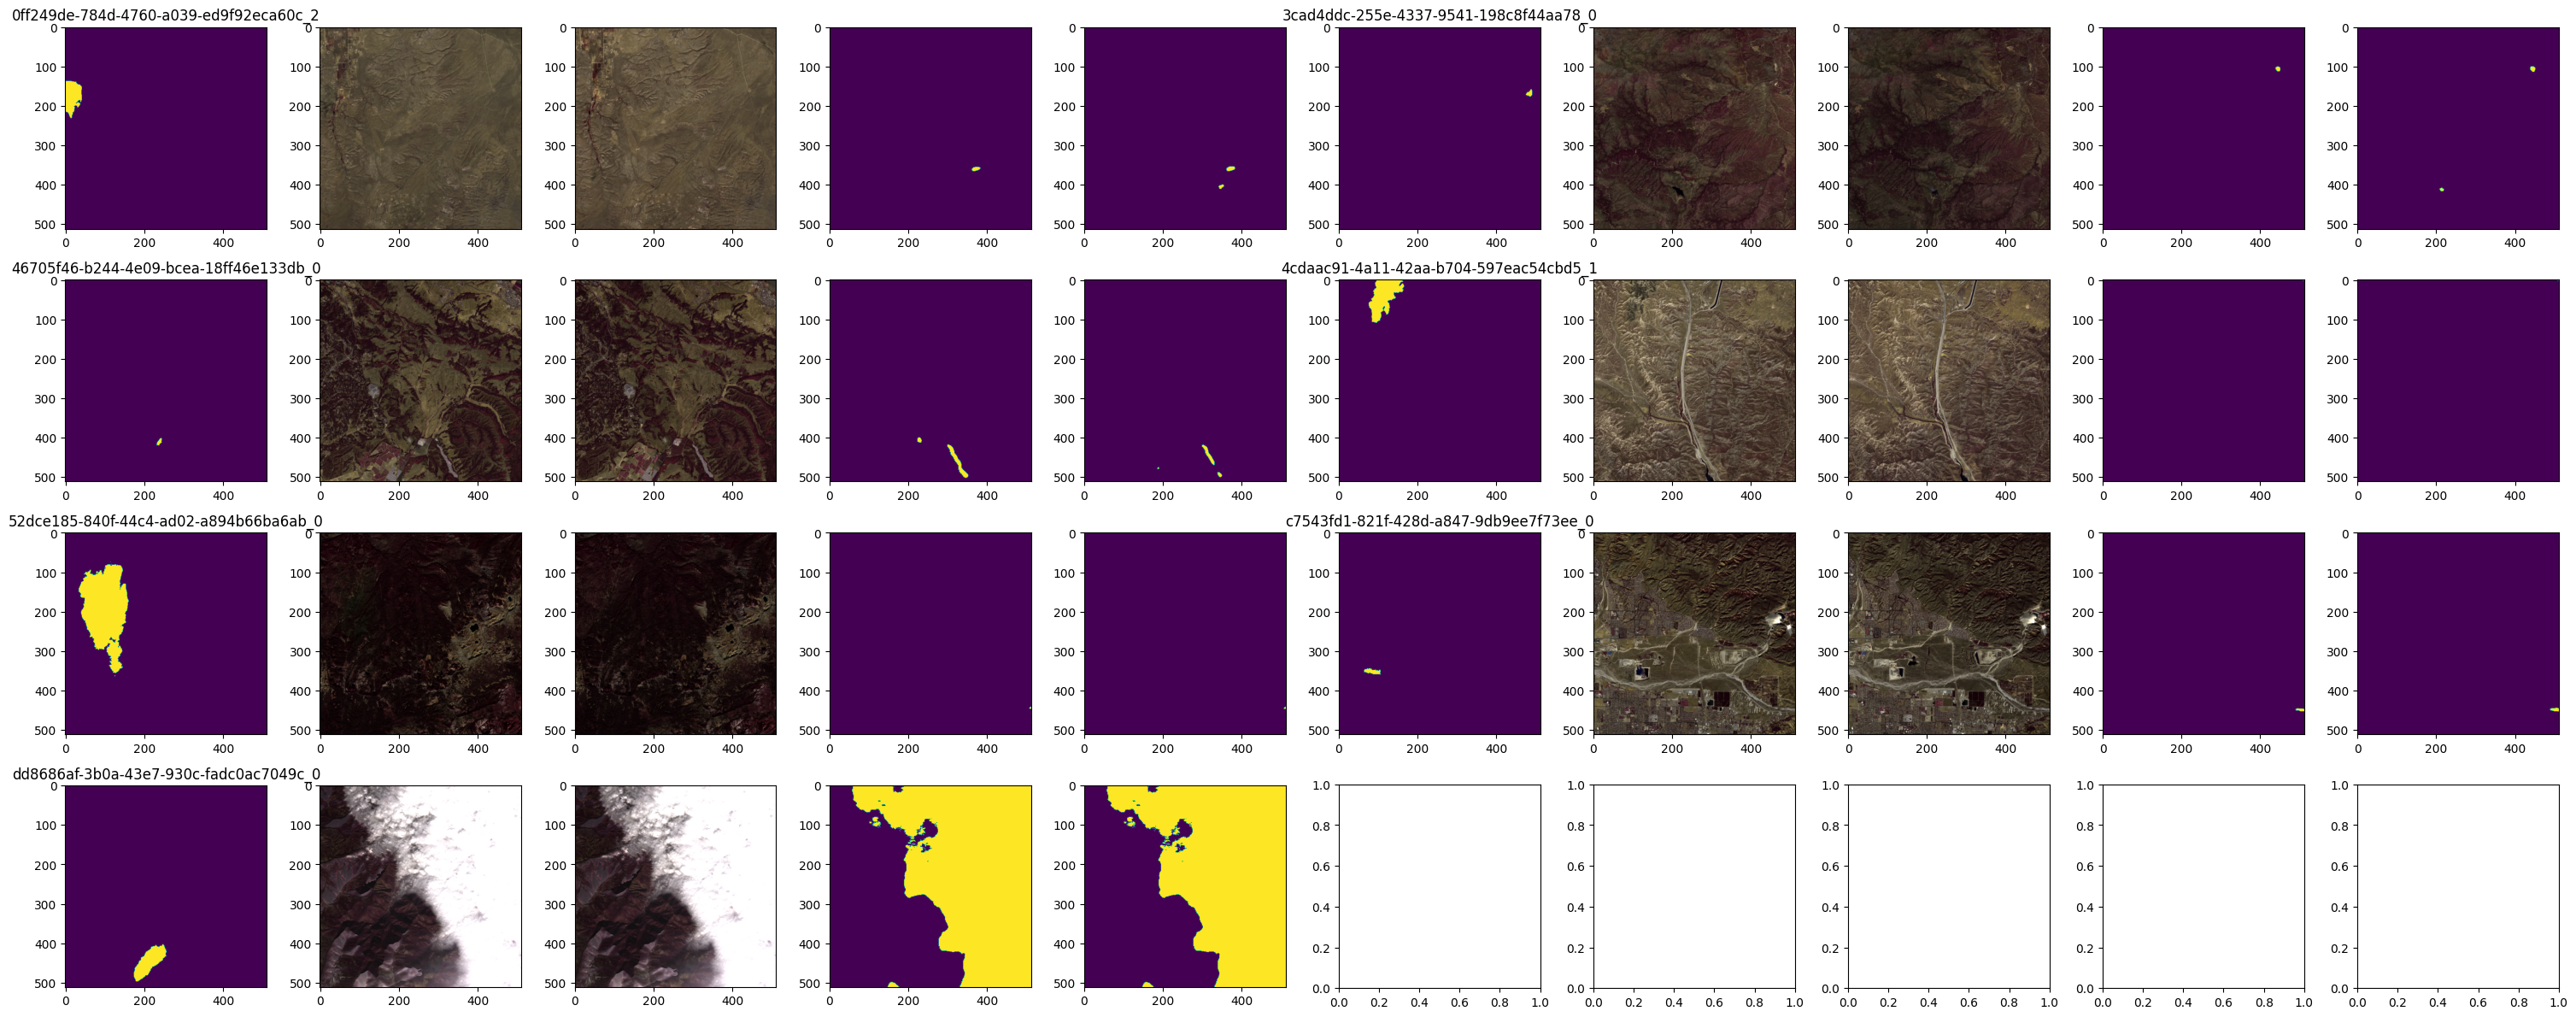

In [97]:
PANEL_SIZE = 3
n_cols = 10
n_rows = int(np.ceil(len(keep_idx)*5 // n_cols + cfg.eps))
print(len(keep_idx), n_rows, n_cols)

fig, axes = plt.subplots(n_rows, n_cols,figsize=(PANEL_SIZE*n_cols,PANEL_SIZE*n_rows), tight_layout=True)
axes = axes.ravel()
j=0
result_scores = {}
for k in keep_idx:
    name = pair_df['name'].iloc[k]
    mask_path = pair_df['mask'].iloc[k]
    mask = np.load(mask_path).squeeze()
    pre_proba = np.zeros((512,512))
    pos_proba = np.zeros((512,512))
    for i in range(4):
        OUTPUT_ROOT = f'../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold{i}/inference_cloud/visualize/'
        if i==0:
            pre_image = cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pre_2348.png'))
            pos_image = cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pos_2348.png'))
            pre_image = cv2.cvtColor(pre_image, cv2.COLOR_BGR2RGB)
            pos_image = cv2.cvtColor(pos_image, cv2.COLOR_BGR2RGB)
        pre_proba += cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pre_predict.png'),0)
        pos_proba += cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pos_predict.png'),0)
    pre_proba /= 4
    pos_proba /= 4
    pre_pred = pre_proba>thr_pxl
    pos_pred = pos_proba>thr_pxl

    # metrics
    tp = (pos_pred * mask).sum()
    tn = ((1. - pos_pred) * (1. - mask)).sum()
    fp = (pos_pred * (1. - mask)).sum()
    fn = ((1. - pos_pred) * mask).sum()

    precision = tp / (tp + fp + cfg.eps)
    recall = tp / (tp + fn + cfg.eps)
    f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
    iou = tp / (tp + fp + fn + cfg.eps)

    result_scores[name] = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou,
    }

    axes[j].imshow(mask)
    axes[j].set_title(name)
    j+=1
    axes[j].imshow(pre_image)
    j+=1
    axes[j].imshow(pos_image)
    j+=1
    axes[j].imshow(pre_pred)
    j+=1
    axes[j].imshow(pos_pred)
    j+=1
plt.show()

In [98]:
result_scores_df = pd.DataFrame(result_scores).T
print(result_scores_df.shape)
display(result_scores_df.mean())

(7, 8)


tp                0.000000
tn           236234.571429
fp            21025.857143
fn             4883.571429
precision         0.000000
recall            0.000000
f1                0.000000
iou               0.000000
dtype: float64

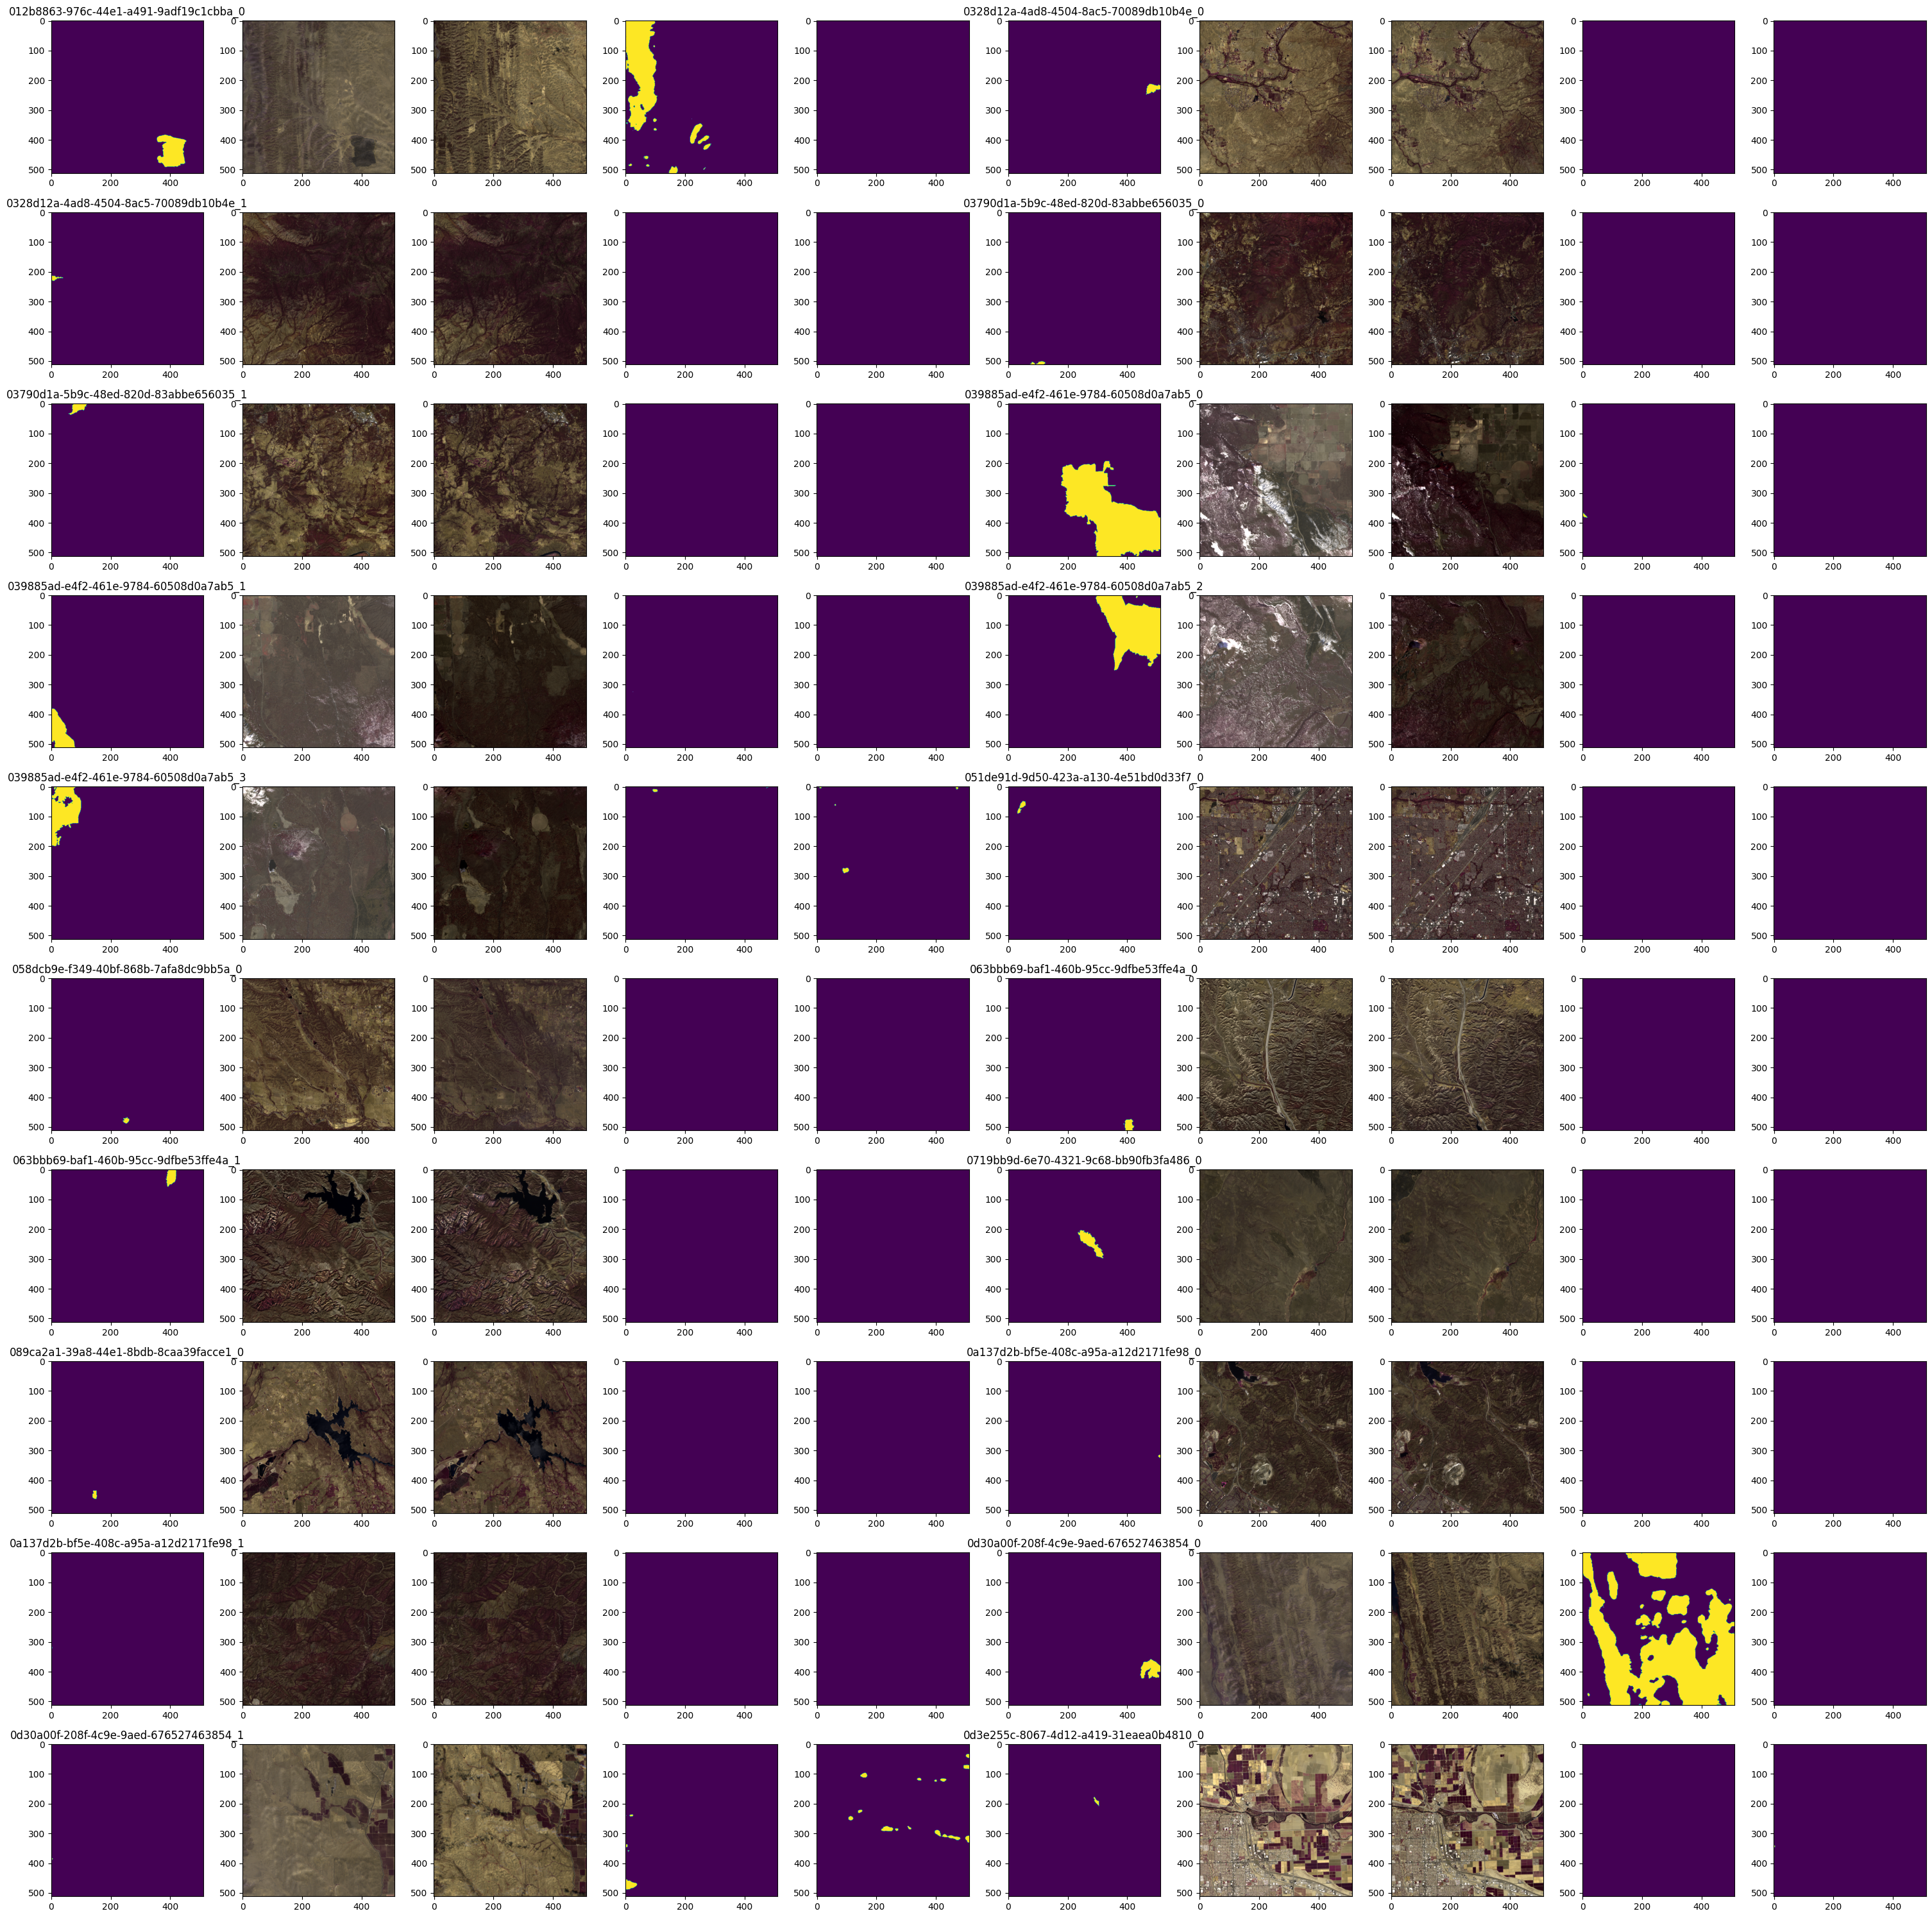

In [99]:
PANEL_SIZE = 3
n_cols = 10
n_rows = 10

fig, axes = plt.subplots(n_rows, n_cols,figsize=(PANEL_SIZE*n_cols,PANEL_SIZE*n_rows), tight_layout=True)
axes = axes.ravel()
j=0
for k in range(n_cols*n_rows//5):
    name = pair_df['name'].iloc[k]
    mask_path = pair_df['mask'].iloc[k]
    mask = np.load(mask_path).squeeze()
    pre_proba = np.zeros((512,512))
    pos_proba = np.zeros((512,512))
    for i in range(4):
        OUTPUT_ROOT = f'../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold{i}/inference_cloud/visualize/'
        if i==0:
            pre_image = cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pre_2348.png'))
            pos_image = cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pos_2348.png'))
            pre_image = cv2.cvtColor(pre_image, cv2.COLOR_BGR2RGB)
            pos_image = cv2.cvtColor(pos_image, cv2.COLOR_BGR2RGB)
        pre_proba += cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pre_predict.png'),0)
        pos_proba += cv2.imread(os.path.join(OUTPUT_ROOT,name+'_pos_predict.png'),0)
    pre_proba /= 4
    pos_proba /= 4
    pre_pred = pre_proba>thr_pxl
    pos_pred = pos_proba>thr_pxl

    axes[j].imshow(mask)
    axes[j].set_title(name)
    j+=1
    axes[j].imshow(pre_image)
    j+=1
    axes[j].imshow(pos_image)
    j+=1
    axes[j].imshow(pre_pred)
    j+=1
    axes[j].imshow(pos_pred)
    j+=1
plt.show()